In [15]:
from __future__ import division

import csv
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import gfile

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('ggplot')
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 999)

### load predictions and error rates

In [16]:
SUBTYPE_LABELS = ['identity_hate', 'insult', 'obscene', 'threat']

SUBTYPE_ERROR_RATES_PATH = 'gs://annotator_models/models/ericagreene/20180528_pseudo_10/error_rates_{}_1287418.csv'
SUBTYPE_PREDICTIONS_PATH = 'gs://annotator_models/models/ericagreene/20180528_pseudo_10/predictions_{}_1287418.csv'

TOXIC_LABELS = ['toxic', 'severe_toxic']

TOXIC_ERROR_RATES_PATH = 'gs://annotator_models/models/ericagreene/20180528_pseudo_10/error_rates_{}_2244103.csv'
TOXIC_PREDICTIONS_PATH = 'gs://annotator_models/models/ericagreene/20180528_pseudo_10/predictions_{}_2244103.csv'

LABELS = SUBTYPE_LABELS + TOXIC_LABELS

In [17]:
# Load error rates data and put it in df_acc

cols = ['_worker_index', 'annotator_id', 'n_annotations', 'accuracy_rate_0','accuracy_rate_1','label']
df_acc = pd.DataFrame(columns = cols)

def load_error_rates(label, path): 
    with gfile.Open(path.format(label), 'rb') as f:
        df = pd.read_csv(f, encoding='utf-8')
        df['label'] = label        
    return df

for label in SUBTYPE_LABELS:
    try:
        df = load_error_rates(label, SUBTYPE_ERROR_RATES_PATH)
        df_acc = pd.concat([df, df_acc])
    except:
        print('could not load error rates for', label)
    
for label in TOXIC_LABELS:
    try:
        df = load_error_rates(label, TOXIC_ERROR_RATES_PATH)
        df_acc = pd.concat([df, df_acc])    
    except:
        print('could not load error rates for', label)

In [18]:
# Load prediction data and put it in df_labels

cols = ['comment_id','mean','hat_0','hat_l','hat_mean','_unit_index',
        'annotator_id','comment_text','insult','usage','label','diff']
df_labels = pd.DataFrame(columns = cols)

def load_predictions(label, path): 
    with gfile.Open(path.format(label), 'rb') as f:
        df = pd.read_csv(f, encoding='utf-8')
        
        df = df.rename(columns={
            label + '_mean': 'mean',
            label +'_hat_0': 'hat_0', 
            label + '_hat_1': 'hat_l',
            label + '_hat_mean': 'hat_mean'
        })
        
        df['label'] = label        
        df['diff'] = df['hat_mean'] - df['mean']
        
    return df

for label in SUBTYPE_LABELS:
    try:
        df = load_predictions(label, SUBTYPE_PREDICTIONS_PATH)
        df_labels = pd.concat([df, df_labels])
    except:
        print('unable to load predictions for', label)
    
for label in TOXIC_LABELS:
    try:
        df = load_predictions(label, TOXIC_PREDICTIONS_PATH)
        df_labels = pd.concat([df, df_labels])
    except:
        print('unable to load predictions for', label)

In [19]:
df_labels.sort_values(by='diff', ascending=False)[['mean', 'hat_mean', 'diff', 'label','comment_text']][0:3]

,mean,hat_mean,diff,label,comment_text
66179,0.300000,0.979566,0.679566,severe_toxic,Fuck my stupid muslim ass!!!!!!!!!
3442,0.307692,0.982629,0.674937,severe_toxic,"Fuck you, Wknight94."
1372,0.300000,0.973480,0.673480,severe_toxic,JAN MOIR IS A VILE SLAG- SACK THE BITCH FROM THE DAILY MAIL


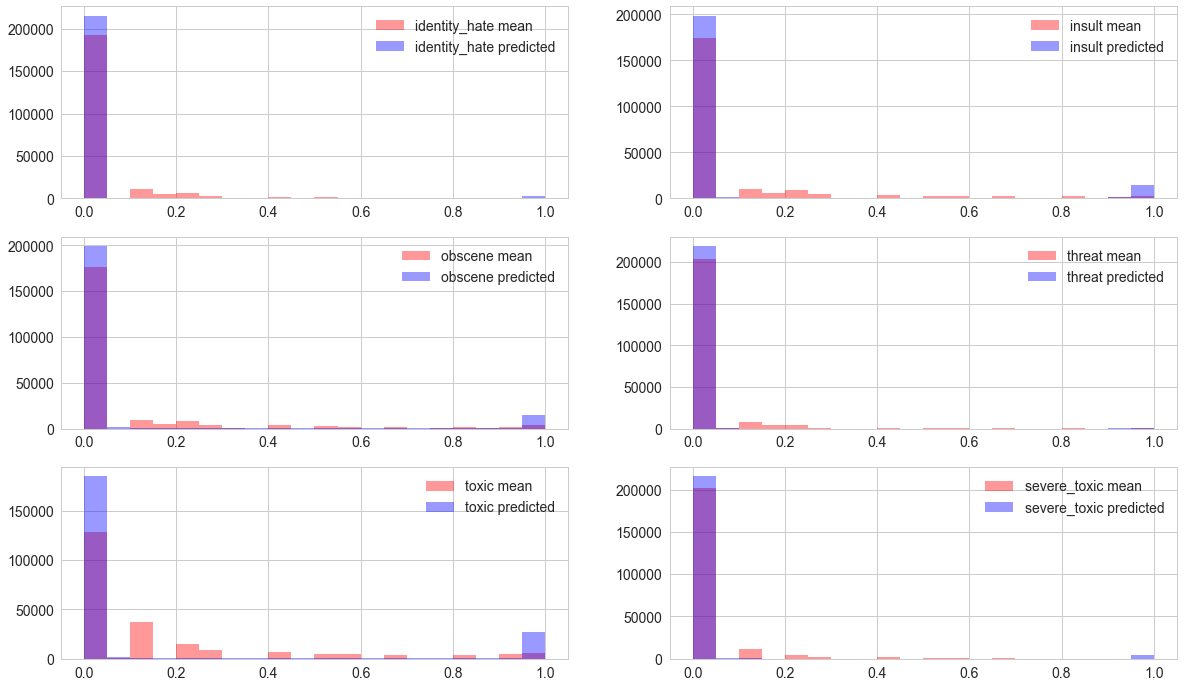

In [26]:
N_BINS = 20

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(20, 12))

counter = 0

for i in range(3):
    for j in range(2):
        label = LABELS[counter]
        label_mean = label + '_mean'
        label_hat = label + '_hat'
        counter += 1
        
        data = df_labels[df_labels['label'] == label]
    
        sns.distplot(data['mean'], label=label + ' mean', bins=N_BINS, kde=False, 
                     kde_kws={'clip': (-1, 1)}, ax=axes[i,j], color='r')
        sns.distplot(data['hat_mean'], label=label + ' predicted', bins=N_BINS, kde=False,
                     kde_kws={'clip': (-1, 1)}, ax=axes[i,j], color='b')
        axes[i,j].legend()
        axes[i,j].set_xlabel('')
   

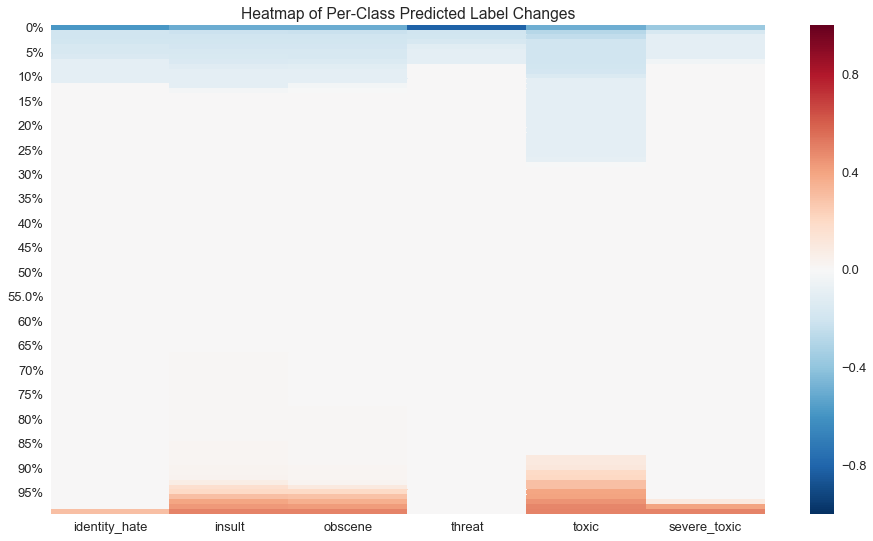

In [25]:
percentiles = [i/100.0 for i in range(0,100)]

plt.figure(figsize=(16,9))

df_diffs = pd.DataFrame(columns=LABELS)
for label in LABELS:
    df_diff_percentiles = df_labels[df_labels['label']==label]['diff'].describe(percentiles=percentiles)[4:-1]
    df_diffs[label] = df_diff_percentiles
    
sns.heatmap(df_diffs, yticklabels=5, vmin=-1, vmax=1, cmap="RdBu_r")
plt.title('Heatmap of Per-Class Predicted Label Changes')
plt.show()

## plot worker error rates

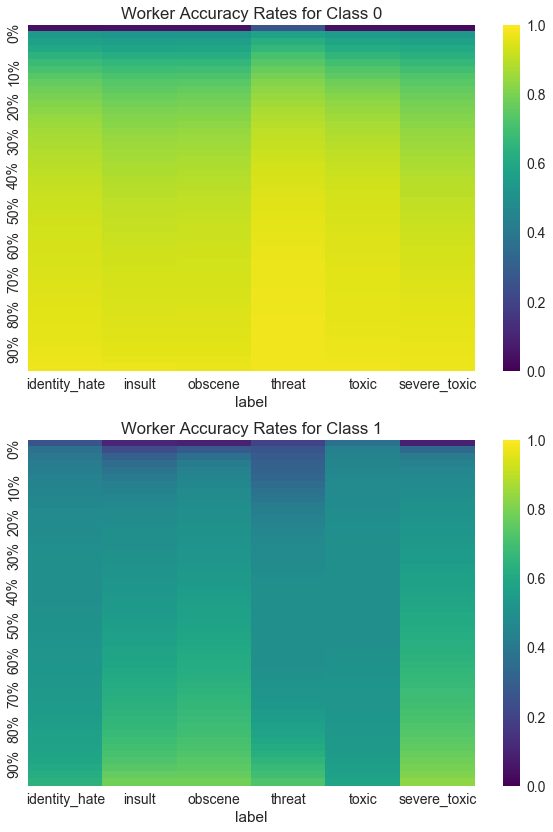

In [27]:
percentiles = [i/50.0 for i in range(0,50)]
LABELS = SUBTYPE_LABELS + TOXIC_LABELS

colors = cmap = sns.cubehelix_palette(light=1, as_cmap=True, start=.5, rot=-.75)

fig, axes = plt.subplots(2, 1, figsize=(10,14))

df_acc_0 = df_acc.pivot(columns='label', values='accuracy_rate_0')
sns.heatmap(df_acc_0.describe(percentiles=percentiles)[4:-1],
            yticklabels=5, vmin=0, vmax=1, cmap='viridis', xticklabels=LABELS, ax=axes[0])

axes[0].set_title('Worker Accuracy Rates for Class 0')

df_acc_1 = df_acc.pivot(columns='label', values='accuracy_rate_1')
sns.heatmap(df_acc_1.describe(percentiles=percentiles)[4:-1],
            yticklabels=5, vmin=0, vmax=1, cmap='viridis', xticklabels=LABELS, ax=axes[1])

plt.title('Worker Accuracy Rates for Class 1')
plt.legend()
plt.show()

colors = sns.light_palette((210, 90, 60), input="husl", as_cmap=True)

#df_marginals_predicted = pd.DataFrame(100 * (df[LABELS].round(0).sum() / len(df)), columns=['Predicted Class Marginals'])\
#  .rename({label + '_hat': label for label in LABELS})

#df_marginals_mean = pd.DataFrame(100 * (df[LABELS].round(0).sum() / len(df)), columns=['Mean Class Marginals'])\
#  .rename({label + '_mean': label for label in LABELS})

#df_marginals = pd.concat([df_marginals_mean, df_marginals_predicted], axis=1)
#df_marginals['Percent Diff'] =  100 * (df_marginals['Predicted Class Marginals'] - df_marginals['Mean Class Marginals']) /  df_marginals['Mean Class Marginals']
#df_marginals.style.background_gradient(cmap=colors, axis=0, subset='Percent Diff')

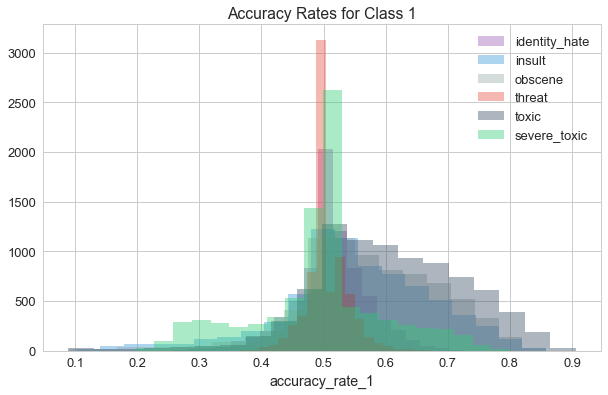

Text(0.5,1,'Accuracy Rates for Class 0')

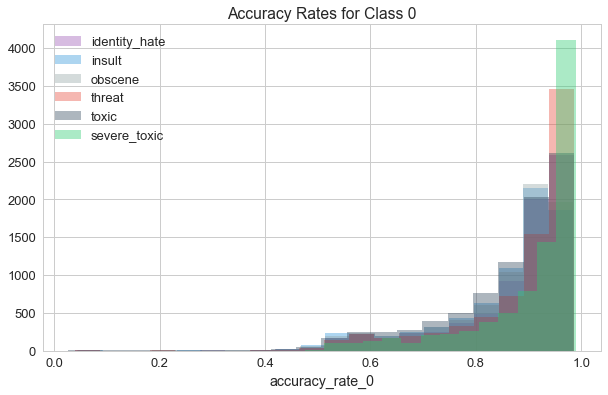

In [23]:
LABELS = SUBTYPE_LABELS + TOXIC_LABELS

sns.set(font_scale=1.3)
sns.set_style("whitegrid")

N_BINS=20
plt.figure(figsize=(10,6))

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui)

for i,label in enumerate(LABELS):
    data = df_acc[df_acc['label'] == label]['accuracy_rate_1']
    sns.distplot(data, label=label, bins=N_BINS, kde=False, color=colors[i])
  
plt.legend()
plt.title('Accuracy Rates for Class 1')  
plt.show()

plt.figure(figsize=(10,6))
for i,label in enumerate(LABELS):
    data = df_acc[df_acc['label'] == label]['accuracy_rate_0']
    sns.distplot(data, label=label, bins=N_BINS, kde=False, color=colors[i])
  
plt.legend()
plt.title('Accuracy Rates for Class 0')  

## plot comment score diffs for certain words

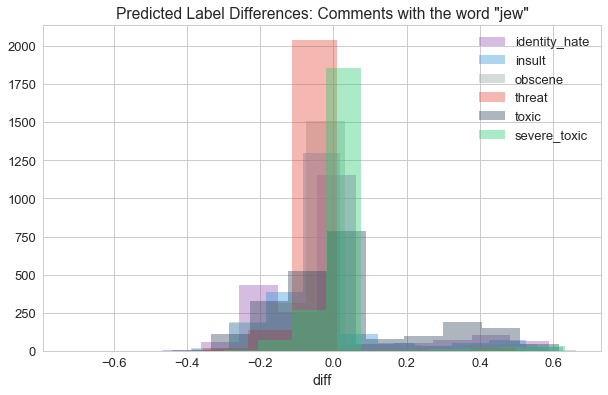

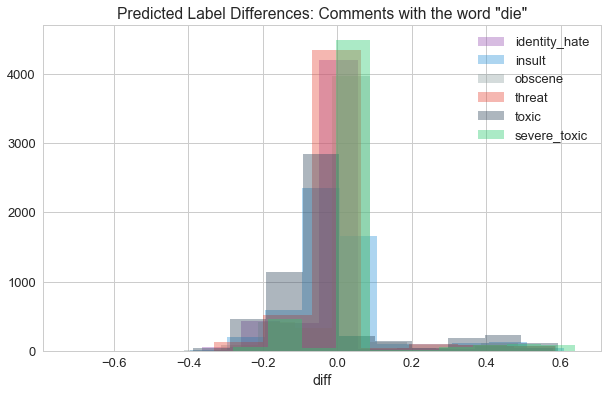

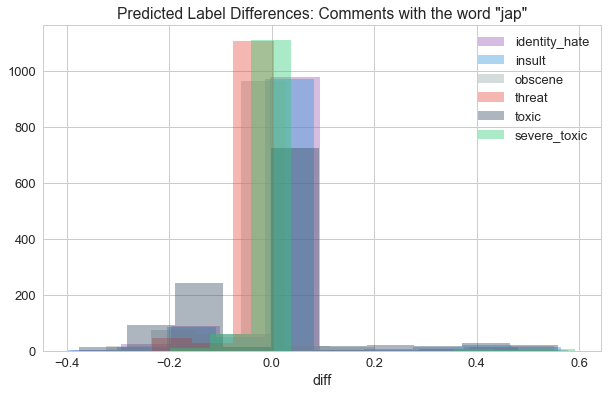

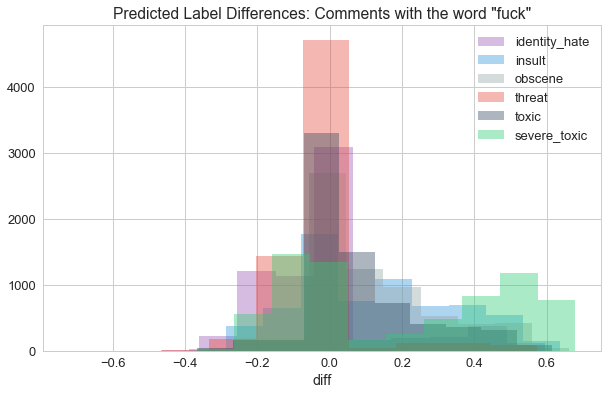

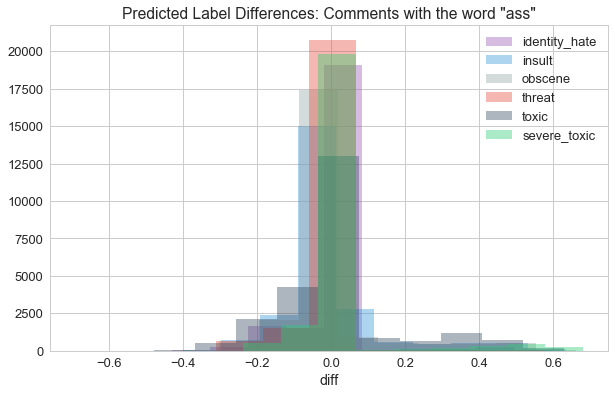

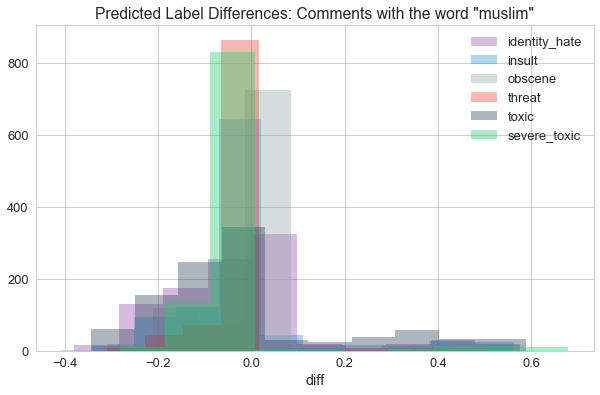

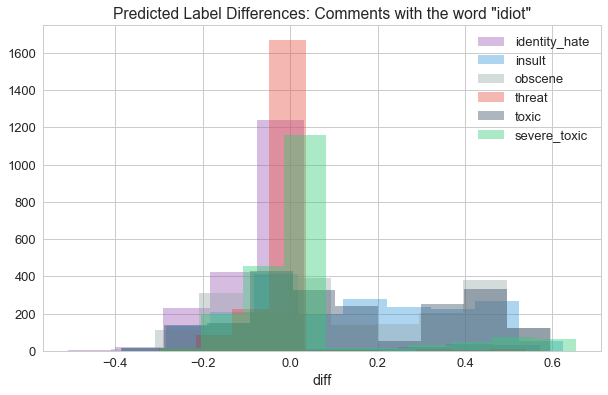

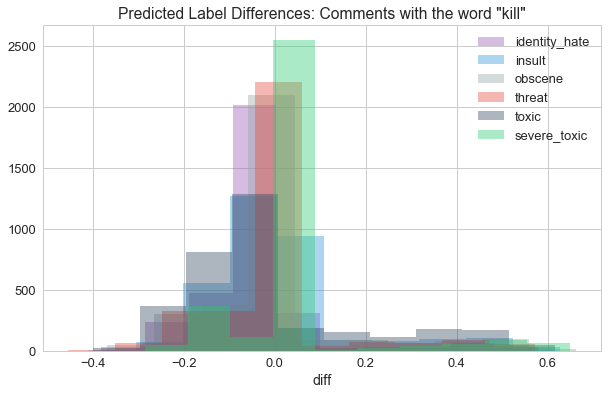

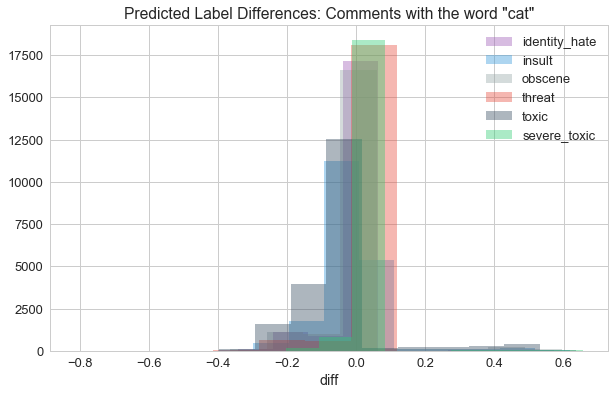

In [24]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui)

N_BINS = 10
words = ['jew', 'die', 'jap', 'fuck', 'ass', 'muslim', 'idiot', 'kill', 'cat']

df_labels['comment_text_lower'] = df_labels['comment_text'].str.lower()

for word in words:
    plt.figure(figsize=(10,6))

    df_word = df_labels[df_labels['comment_text_lower'].str.contains(word) == True]

    for i,label in enumerate(LABELS):
        data = df_word[df_word['label'] == label]['diff']

        sns.distplot(data, label=label, bins=N_BINS, kde=False, color=colors[i])

    plt.legend()
    plt.title('Predicted Label Differences: Comments with the word "{0}"'.format(word))
    plt.show()

## write out results to hand annotate


In [29]:
n_examples = 100
random_state = 876512

# split into 50 buckets by abs value of the diff and sample from top 5 
# create new spreadsheet
# spreadsheet_id = sheets.create_spreadsheet('Dawid Skene Predictions -- 10/5/2018')

n_bins = 25 # max number of bins to equally sample from when creating data to annotate by hand
n_samples = 50 # number of comments to sample from each bin

df_labels['abs_diff'] = df_labels['diff'].abs()

for label in LABELS:
    cols = ['comment_text', 'mean', 'hat_mean', 'diff', 'abs_diff', 'comment_id']
  
    # calculate the cutoffs for the bins
    data = df_labels[df_labels['label'] == label]
    _, bins_all = pd.qcut(data['abs_diff'], n_bins, duplicates='drop', retbins=True)
  
    bins = list(bins_all[-3:])
    print label, len(bins_all)
    print label, bins
  
    sampled_unit_ids = []
    for i in range(len(bins) - 1):
        min_val = bins[i]
        max_val = bins[i+1]
        
        df_diff_segment = data[(data['diff'] >= min_val) & (data['diff'] <= max_val)]
        new_unit_ids = list(df_diff_segment.sample(n_samples, random_state=random_state)['comment_id'])
        sampled_unit_ids += new_unit_ids

    df_label_sampled = data[data['comment_id'].isin(sampled_unit_ids)][cols]
    
    # write to disk 
    filename = label + '_sampled_for_annotation.csv'
    df_label_sampled.to_csv(filename, encoding='utf-8')
    
    # add a tab to that spreadsheet with comments that we predict are bad
    # but the raters thought were not bad
    #tab_name = label
    #worksheet_id = sheets.add_worksheet(spreadsheet_id, tab_name)
    #sheets.update_cells(spreadsheet_id, worksheet_id, df_label_sampled, include_col_header=True)  

identity_hate 26
identity_hate [0.11103227, 0.19551310000000002, 0.59575751]
insult 26
insult [0.19692146000000002, 0.2999814500000001, 0.66214371]
obscene 26
obscene [0.19506066, 0.29981174, 0.66128936]
threat 26
threat [0.00218709, 0.1650605, 0.81190735]
toxic 26
toxic [0.29545644320000003, 0.39987277880000005, 0.6569469800000001]
severe_toxic 26
severe_toxic [0.09881388320000001, 0.1626776960000001, 0.67956598]


In [ ]:
sampled_unit_ids